# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, lane boundaries of single road images and sequences of road images (videos) are detected. 

The following methods are used for the processing:

* Colorspace Transformation
* Color Selection
* Gaussian Smoothing
* Canny Edge Detection
* Region of Interest Selection
* Hough Line Detection
* Least-Squares Fitting
* Using History for Smoothing (only for videos)

Execute the blocks below and see how the pipeline works on example images and videos. You can tune the parameters to optimze the pipeline on your data samples.

---

## Import Packages

In [123]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


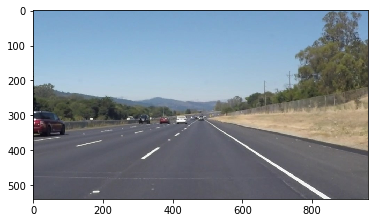

In [124]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Configuration Paramters

Here you can adjust the parameters of the pipelines' algorithms.

In [125]:
from types import SimpleNamespace
config = {
    'lower_white': np.uint8([  0, 205,   0]), # lower threshold for white color in HSL
    'upper_white': np.uint8([255, 255, 255]), # upper threshold for white color in HSL
    'lower_yellow': np.uint8([ 10,   0, 100]), # lower threshold for yellow color in HSL
    'upper_yellow': np.uint8([ 40, 255, 255]), # upper threshold for yellow color in HSL
    'kernel_size': 7, # Gaussian noise kernel size
    'rho': 2, # distance resolution of the accumulator in pixels
    'theta': np.pi/180, # angle resolution of the accumulator in radians
    'threshold': 30, # accumulator threshold parameter
    'min_line_len': 40, # line segments shorter than this parameter are rejected
    'max_line_gap': 100, # maximum allowed gap between points on the same line to link them
}
config = SimpleNamespace(**config)

## Helper Functions

This helper functions provide the functionality of the pipeline.

In [134]:
import math
import warnings
import matplotlib.ticker as ticker

def convert_rgb_to_hsl(img):
    """Converts RGB iamge to HSL colorspace"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

def extract_white_yellow_hls(img):
    """
    Extracts all white and yellow pixels in HSL colorspace
    
    This function expects an image in the HSL format. Make sure
    you have converted your image to this colorspace. Yellow and white pixels
    are extracted based on an upper and lower threshold. 
    """
    white_mask = cv2.inRange(img, config.lower_white, config.upper_white)
    yellow_mask = cv2.inRange(img, config.lower_yellow, config.upper_yellow)
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    return cv2.bitwise_and(img, img, mask = mask)

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    rgb_image = cv2.cvtColor(img, cv2.COLOR_HLS2RGB)
    return cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def auto_canny(img, sigma=0.33):
    """Applies the Canny transform with auto threshold"""
    
    # compute the median of the single channel pixel intensities
    median_intensity = np.median(img)
 
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * median_intensity))
    upper = int(min(255, (1.0 + sigma) * median_intensity))
    
    return cv2.Canny(img, lower, upper)
 

def gaussian_blur(img):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (config.kernel_size, config.kernel_size), 0)

def region_of_interest_mask(img):
    """
    Constructs an image mask
    
    The region of interest has 4 vertices, which are 
    calculated based on the image dimension.
    """
    shape_img = img.shape
    vertices = np.array([[
        (0,shape_img[0]),
        ((9*shape_img[1])/20, (3*shape_img[0])/5),
        ((11*shape_img[1])/20, (3*shape_img[0])/5),
        (shape_img[1],shape_img[0])
    ]], dtype=np.int32)
    return vertices

def region_of_interest(img, vertices):
    """
    Applies an image mask
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def construct_lane_boundaries(lines):
    """
    Calculates left and right lane boundary coeffiecients

    The detcetd lines by the hough line algorithm are seperated
    into two groups: left lane boundary and right lane boundary.
    Non-fitting lines (e.g. vertical lines) are omitted. For both
    groups a least squre fitting line is determined and returned.
    """
    if lines is None:
        return None, None
    
    right_lane_boundary_x = []
    right_lane_boundary_y = []
    left_lane_boundary_x = []
    left_lane_boundary_y = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            # skip vertical lines
            if abs(x1 - x2) > 0:
                slope = (y2 - y1)/(x2 - x1)
                if -0.9 < slope < -0.4:
                    left_lane_boundary_x.append(x1)
                    left_lane_boundary_x.append(x2)
                    left_lane_boundary_y.append(y1)
                    left_lane_boundary_y.append(y2)
                elif 0.4 < slope < 0.9:
                    right_lane_boundary_x.append(x1)
                    right_lane_boundary_x.append(x2)
                    right_lane_boundary_y.append(y1)
                    right_lane_boundary_y.append(y2)

    left_lane_coeffs = None
    if len(left_lane_boundary_x) > 0 and len(left_lane_boundary_y) > 0:
        left_lane_coeffs = np.polyfit(left_lane_boundary_x, left_lane_boundary_y, 1)
    
    right_lane_coeffs = None
    if len(right_lane_boundary_x) > 0 and len(right_lane_boundary_y) > 0:
        right_lane_coeffs  = np.polyfit(right_lane_boundary_x, right_lane_boundary_y, 1)
        
    return left_lane_coeffs, right_lane_coeffs

def draw_lines(img, left_lane_coeffs, right_lane_coeffs, color=[255, 0, 0], thickness=2, focus_y2=320):
    """
    Draw left and right lane boundary line
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    """
    
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    if left_lane_coeffs is not None:
        left_lane_slope = left_lane_coeffs[0]
        left_lane_intercept = left_lane_coeffs[1]
        y1 = img.shape[0]
        y2 = focus_y2
        x1 = (y1 - left_lane_intercept)/left_lane_slope
        x2 = (y2 - left_lane_intercept)/left_lane_slope
        cv2.line(line_img, (int(x1), int(y1)), (int(x2), int(y2)), color, thickness)
    else:
        warnings.warn("No left boundary!")
    
    if right_lane_coeffs is not None:
        right_lane_slope = right_lane_coeffs[0]
        right_lane_intercept = right_lane_coeffs[1]
        y1 = img.shape[0]
        y2 = focus_y2
        x1 = (y1 - right_lane_intercept)/right_lane_slope
        x2 = (y2 - right_lane_intercept)/right_lane_slope
        cv2.line(line_img, (int(x1), int(y1)), (int(x2), int(y2)), color, thickness)
    else:
        warnings.warn("No right boundary!")
        
    return line_img
        
def hough_lines(img):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, config.rho, config.theta, config.threshold, \
                            np.array([]), minLineLength=config.min_line_len, \
                            maxLineGap=config.max_line_gap)
    return lines

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

def draw_hough_lines(img, lines):
    """ draw all hough lines """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img,(x1,y1),(x2,y2),(255,0,0),2)

def show_and_save_fig(img, title, output_folder_name, output_file_name, dpi=400):
    """ saves and plots image with specified parameters """
    plt.imshow(img)
    plt.tight_layout()
    plt.title(title)
    plt.axis('off')
    plt.gca().xaxis.set_major_locator(ticker.NullLocator())
    plt.gca().yaxis.set_major_locator(ticker.NullLocator())
    plt.savefig(output_folder_name + output_file_name, \
                dpi=dpi, bbox_inches = 'tight', pad_inches = 0)
    plt.show()
    

## Test Images

In [135]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteRight.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg']

## Lane Finding Pipeline for Single Images

Pipeline executed on single test images. Every step of the pipeline is plotted below. Furthermore, the images are save in the folders `interim/test_images_*` and `test_images_output`. Please make sure that the respective folders exists.

In [136]:
# remove show_and_save_fig for faster processing
    
def process_image(img_file, img_folder="test_images/"):
    """ Pipeline for processing an image file """
    
    print("--- "  + img_file + " start ---")
    
    img = mpimg.imread(img_folder + img_file)
    plt.imshow(img)
    plt.tight_layout()
    plt.title("RGB-Image")
    plt.axis('off')
    plt.gca().xaxis.set_major_locator(ticker.NullLocator())
    plt.gca().yaxis.set_major_locator(ticker.NullLocator())
    plt.show()
    
    hsl_img = convert_rgb_to_hsl(img)
    
    masked = extract_white_yellow_hls(hsl_img)
    show_and_save_fig(cv2.cvtColor(masked, cv2.COLOR_HLS2RGB), "Yellow-and-White-Only", \
                      "interim/test_images_extracted_colors/", img_file)
    
    gray_img = grayscale(masked)
    show_and_save_fig(gray_img, "Grayscale", \
                      "interim/test_images_grayscale/", img_file)
    
    blur_gray_img = gaussian_blur(gray_img)
    show_and_save_fig(blur_gray_img, "Gaussian-Smoothing", \
                      "interim/test_images_gaussian/", img_file)
    
    edges = auto_canny(blur_gray_img)
    show_and_save_fig(edges, "Detected-Edges", \
                      "interim/test_images_edges/", img_file)
    
    roi_mask = region_of_interest_mask(hsl_img)
    show_and_save_fig(cv2.polylines(img.copy(), roi_mask, False, (0,200,0), 2, 4), \
                      "ROI-Mask", "interim/test_images_roi_mask/", img_file)
    
    roi_img = region_of_interest(edges, roi_mask)
    show_and_save_fig(roi_img, "Applied-ROI-Mask", \
                      "interim/test_images_roi_mask_applied/", img_file)
    
    lines = hough_lines(roi_img)
    img_copy = img.copy()
    draw_hough_lines(img_copy, lines)
    show_and_save_fig(img_copy, "Hough-Lines", \
                      "interim/test_images_hough_lines/", img_file)
    
    
    left_lane_coeffs, right_lane_coeffs = construct_lane_boundaries(lines)
    line_img = draw_lines(img, left_lane_coeffs, right_lane_coeffs, [255, 0, 0], 4)
    show_and_save_fig(line_img, "Lane-boundaries", \
                      "interim/test_images_lane_boundaries/", img_file)
    
    w_img = weighted_img(line_img, img)
    show_and_save_fig(w_img, "Combined-Image", \
                      "test_images_output/", img_file)
    
    print("--- "  + img_file + " end ---")



--- solidWhiteCurve.jpg start ---


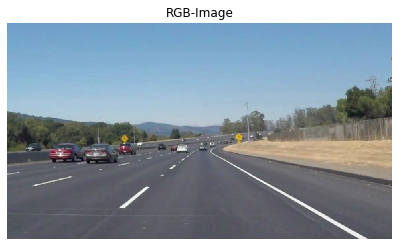

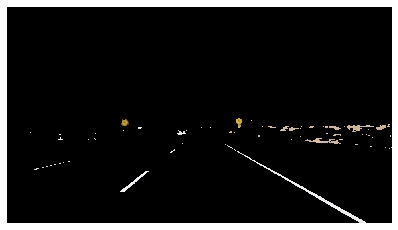

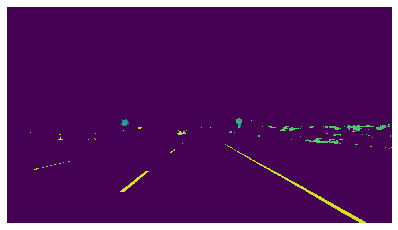

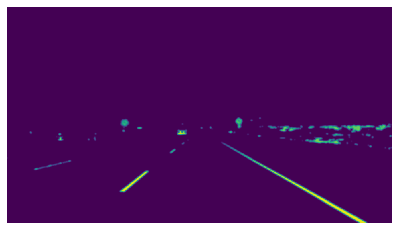

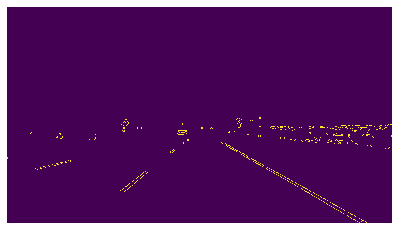

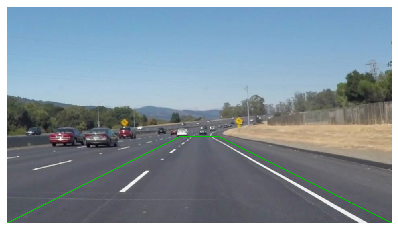

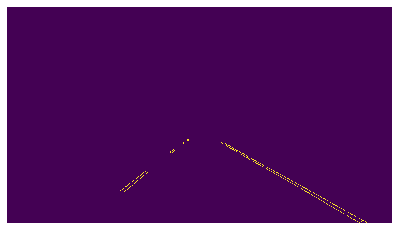

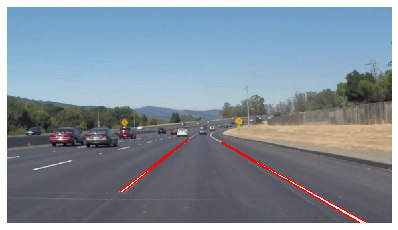

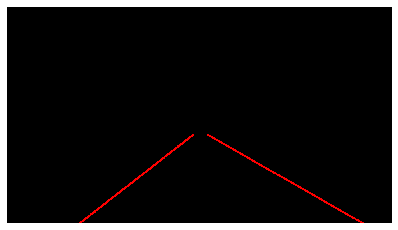

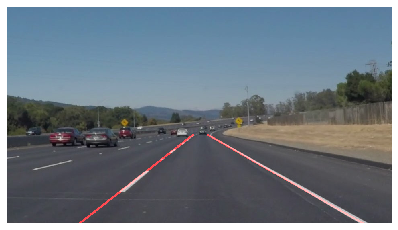

--- solidWhiteCurve.jpg end ---
--- whiteCarLaneSwitch.jpg start ---


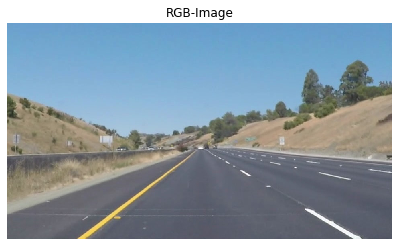

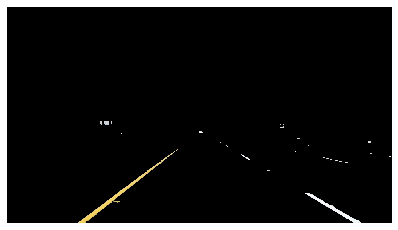

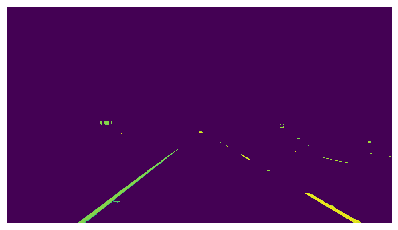

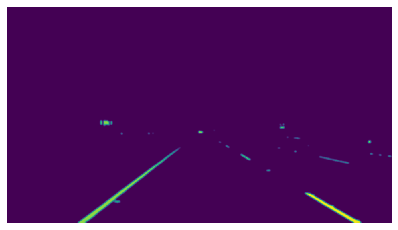

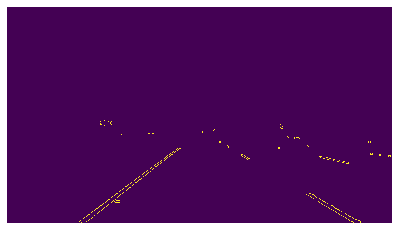

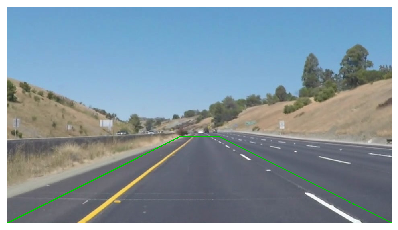

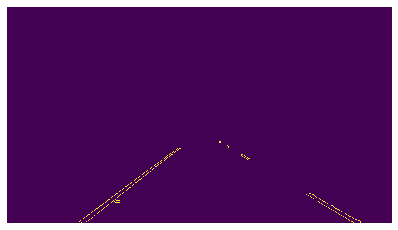

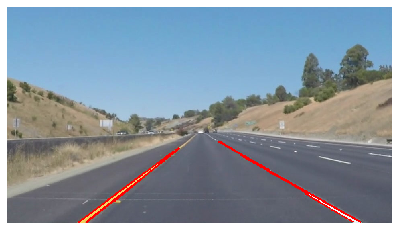

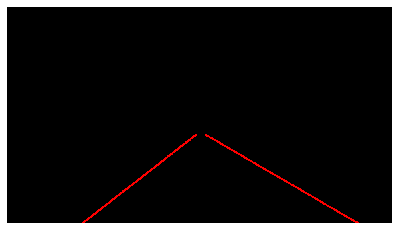

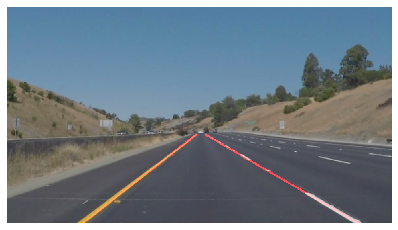

--- whiteCarLaneSwitch.jpg end ---
--- solidWhiteRight.jpg start ---


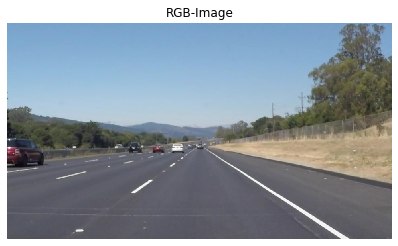

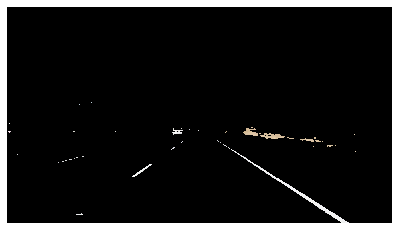

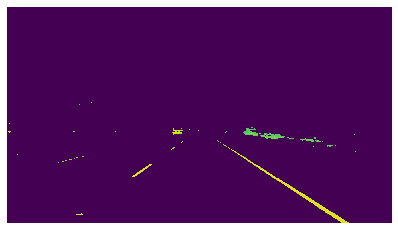

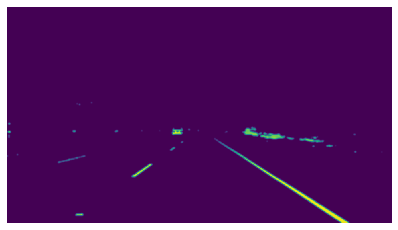

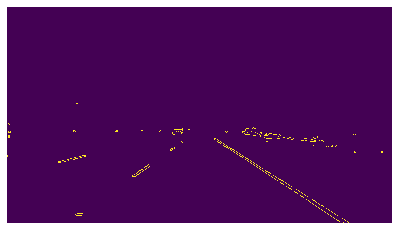

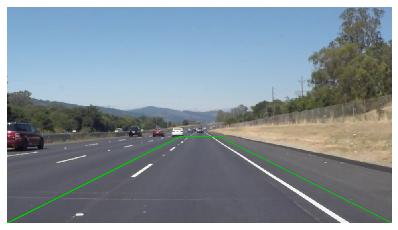

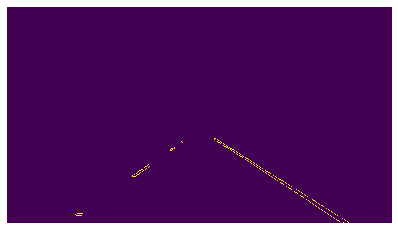

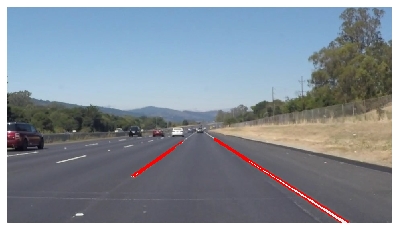

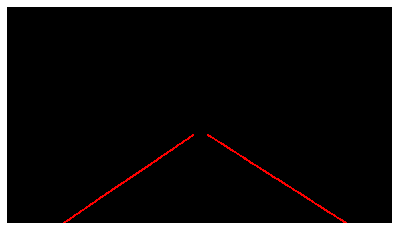

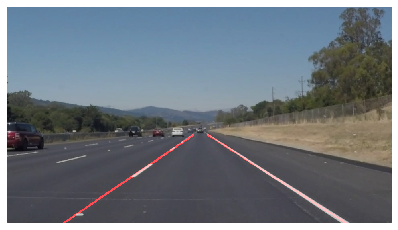

--- solidWhiteRight.jpg end ---
--- solidYellowLeft.jpg start ---


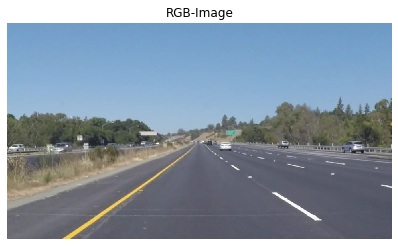

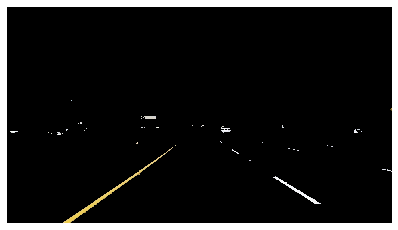

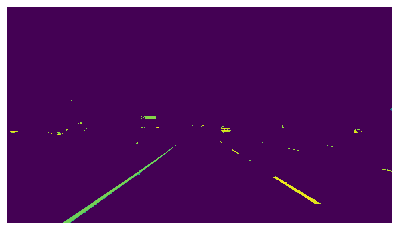

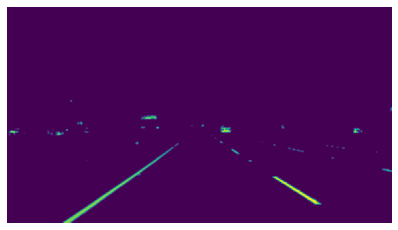

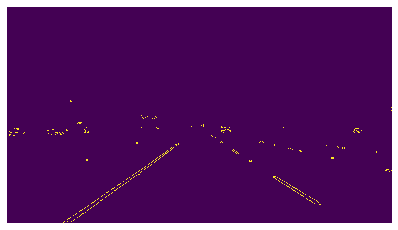

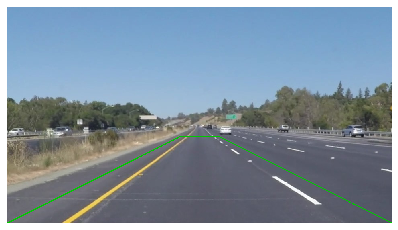

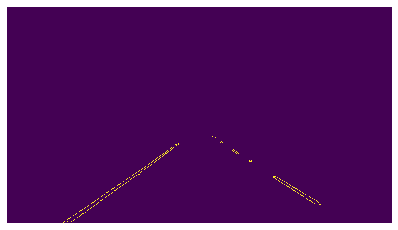

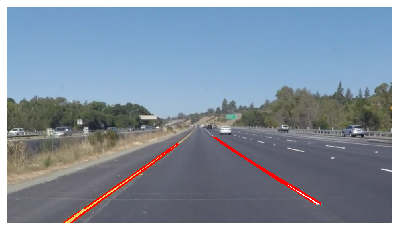

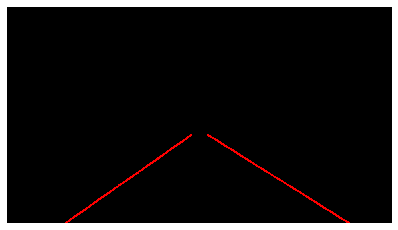

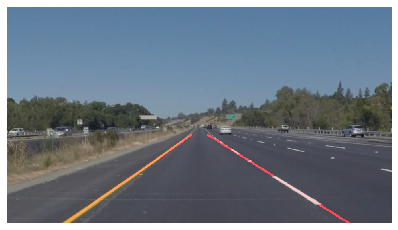

--- solidYellowLeft.jpg end ---
--- solidYellowCurve.jpg start ---


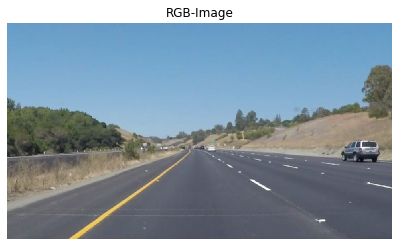

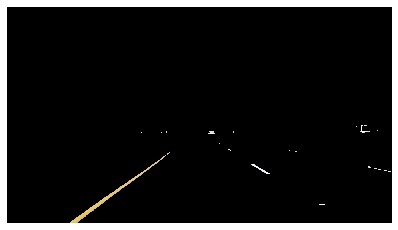

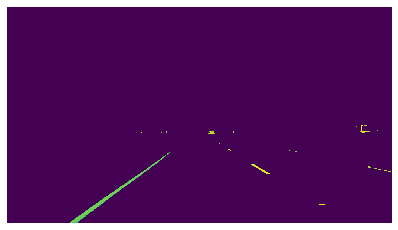

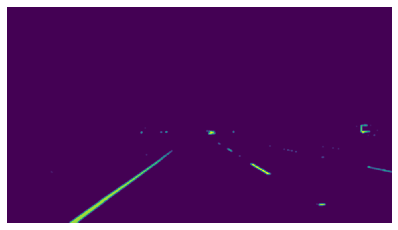

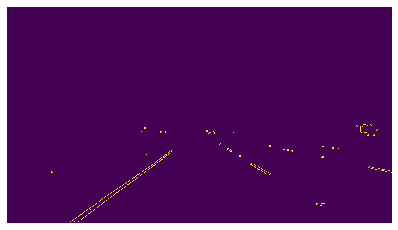

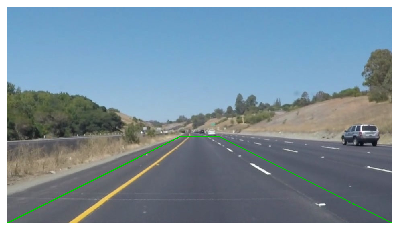

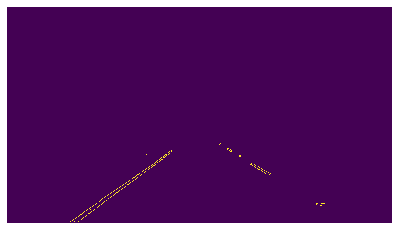

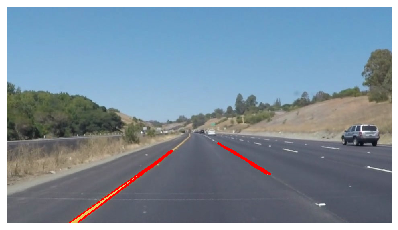

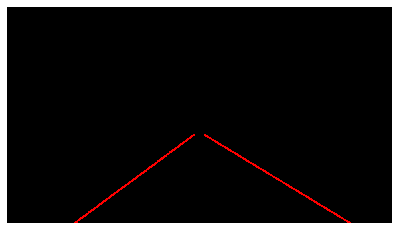

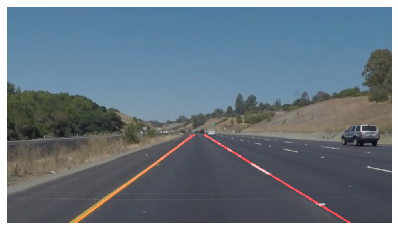

--- solidYellowCurve.jpg end ---
--- solidYellowCurve2.jpg start ---


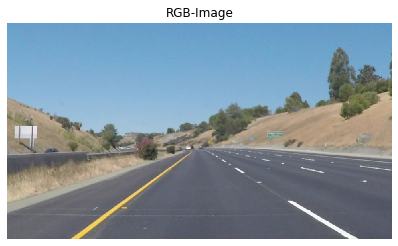

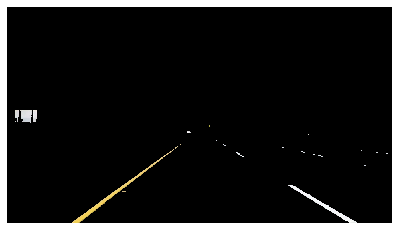

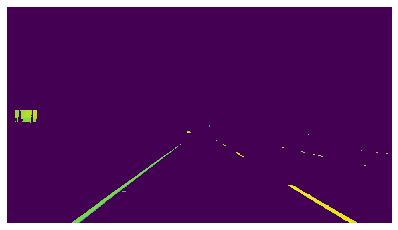

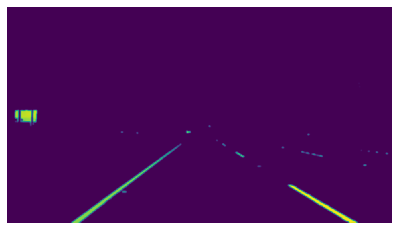

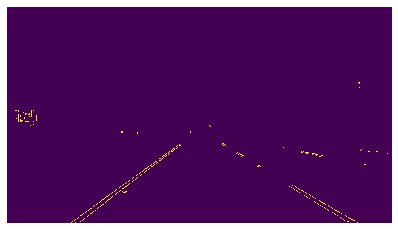

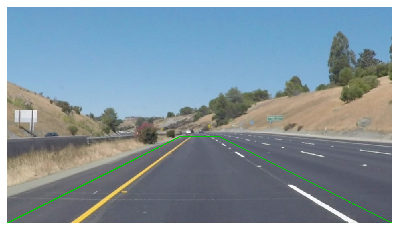

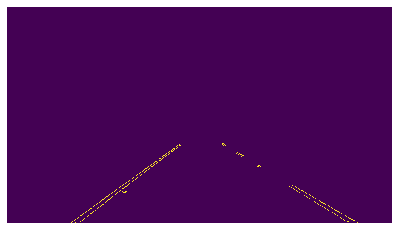

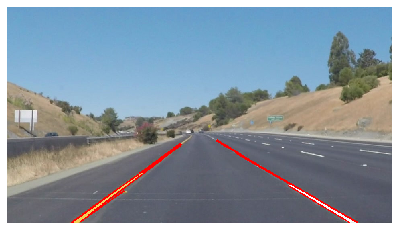

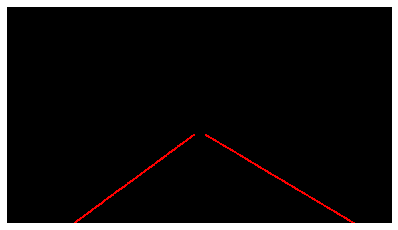

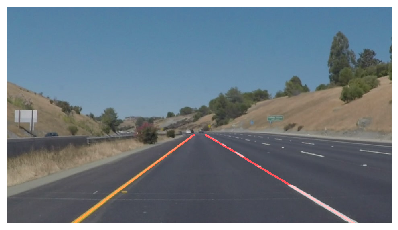

--- solidYellowCurve2.jpg end ---


In [137]:
for img_file in os.listdir("test_images/"):
    process_image(img_file)

#### Test on Videos

We can test our solution on three provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

`challenge.mp4`

The videos are saved in the folder `test_videos_output/`.

In [130]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Lane Finding Pipeline for Videos

In [131]:
from collections import deque

""" Class for detecting lane boundaries of a video file

    This class annotates an image with left and rigth lane
    boundary. Moreover, it keeps track of the history of left
    and right lane boundaries. This history is used to smooth
    the coefficients of the boundaries to avoid shakiness and
    detect high deviations.
"""
class ProcessVideo:
    def __init__(self, focus_y2, memory_size = 5, max_slope_diff = 0.15, max_intercept_diff = 30):
        self.prev_left_lane_coeffs = deque(maxlen=memory_size)
        self.prev_right_lane_coeffs = deque(maxlen=memory_size)
        self.max_slope_diff = max_slope_diff
        self.max_intercept_diff = max_intercept_diff
        self.focus_y2 = focus_y2
        
    def smooth_boundary_coeffs(self, left_lane_coeffs, right_lane_coeffs):
        """ Smooth the current boundary coefficients
    
            The current boundary parameters, slope and intercept, 
            are smoothed based on the boundary coefficients of previous 
            images. Parameters with a too high deviation from previous
            images are omitted and the parameters are calculated based
            on the previous parameters.
        """
        if len(self.prev_left_lane_coeffs) == 0 or len(self.prev_right_lane_coeffs) == 0:
            self.prev_left_lane_coeffs.append(left_lane_coeffs)
            self.prev_right_lane_coeffs.append(right_lane_coeffs)
            return left_lane_coeffs, right_lane_coeffs

        mean_left = np.mean(self.prev_left_lane_coeffs, axis=0)
        mean_right = np.mean(self.prev_right_lane_coeffs, axis=0)
        
        # unpack values
        mean_left_slope = mean_left[0]
        mean_left_intercept = mean_left[1]
        mean_right_slope = mean_right[0]
        mean_right_intercept = mean_right[1]
        
        if left_lane_coeffs is None or \
            abs(mean_left_slope - left_lane_coeffs[0]) > self.max_slope_diff or \
            abs(mean_left_slope - left_lane_coeffs[0]) > self.max_intercept_diff:
            warnings.warn("To high deviation of left boundary coefficients!")
            left_lane_coeffs = mean_left
        else:
            self.prev_left_lane_coeffs.append(left_lane_coeffs)
            left_lane_coeffs = np.mean(self.prev_left_lane_coeffs, axis=0)            

            
        if right_lane_coeffs is None or \
            abs(mean_right_slope - right_lane_coeffs[0]) > self.max_slope_diff or \
            abs(mean_right_slope - right_lane_coeffs[0]) > self.max_intercept_diff:
            warnings.warn("To high deviation of right boundary coefficients!")
            right_lane_coeffs = mean_right
        else:
            self.prev_right_lane_coeffs.append(right_lane_coeffs)
            right_lane_coeffs = np.mean(self.prev_right_lane_coeffs, axis=0)
            
        return left_lane_coeffs, right_lane_coeffs  
        
    def process_image(self, img):
        """ Pipeline for processing the current image """
        
        hsl_img = convert_rgb_to_hsl(img)
        
        masked = extract_white_yellow_hls(hsl_img)
        
        gray_img = grayscale(masked)
        
        blur_gray_img = gaussian_blur(gray_img)
        
        edges = auto_canny(blur_gray_img)
    
        roi_mask = region_of_interest_mask(hsl_img)
    
        roi_img = region_of_interest(edges, roi_mask)
        
        lines = hough_lines(roi_img)
        
        left_lane_coeffs, right_lane_coeffs = construct_lane_boundaries(lines)
        
        smoothed_left_lane_coeffs, smoothed_right_lane_coeffs = \
            self.smooth_boundary_coeffs(left_lane_coeffs, right_lane_coeffs)
        
        line_img = draw_lines(img, smoothed_left_lane_coeffs, \
                              smoothed_right_lane_coeffs, [255, 0, 0], 4, self.focus_y2)
        
        result = weighted_img(line_img, img)
    
        return result

### First Video 

In [132]:
pv_class = ProcessVideo(focus_y2 = 320)

white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(pv_class.process_image)
%time white_clip.write_videofile(white_output, audio=False)

t:   3%|▎         | 6/221 [00:00<00:03, 54.58it/s, now=None]

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: user 9.83 s, sys: 400 ms, total: 10.2 s
Wall time: 9.61 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [133]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

### Second Video with Yellow Markings

In [115]:
pv_class = ProcessVideo(focus_y2 = 340)

yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(pv_class.process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:   1%|          | 5/681 [00:00<00:15, 43.72it/s, now=None]

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
CPU times: user 30.6 s, sys: 1.05 s, total: 31.7 s
Wall time: 30.8 s


In [116]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

### Third Video with Curves

Besides yellow and white markings this video has curvy road segments. Moreover, shadows make it even more difficult to detect the lane boundaries.

In [117]:
pv_class = ProcessVideo(focus_y2 = 450)

challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(pv_class.process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

t:   2%|▏         | 4/251 [00:00<00:08, 29.39it/s, now=None]

Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
CPU times: user 19.1 s, sys: 639 ms, total: 19.8 s
Wall time: 26.8 s


In [118]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))